# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.utils import plot_model

In [0]:
def load_training():
    """
    Load the training set
    """
    abnorm_patches = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    base_patches = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[0::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return abnorm_patches, base_patches, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    abnorm_patches = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    base_patches = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[0::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return abnorm_patches, base_patches, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [0]:
# Load training and test images (abnormalities only, no baseline)
train_abn_images, train_base_images, train_labels= load_training()
test_abn_images, test_base_images, test_labels= load_testing()

# Number of images
n_train_img = train_abn_images.shape[0]
n_test_img = test_abn_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_abn_images.shape[1]
img_h = train_abn_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_abn_images = train_abn_images.reshape((n_train_img, img_w, img_h, 1))
train_base_images = train_base_images.reshape((n_train_img, img_w, img_h, 1))
test_abn_images = test_abn_images.reshape((n_test_img, img_w, img_h, 1))
test_base_images = test_base_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_abn_images = train_abn_images.astype('uint16') / 65535
train_base_images = train_base_images.astype('uint16') / 65535
test_abn_images = test_abn_images.astype('uint16') / 65535
test_base_images = test_base_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_abn_images = train_abn_images[perm]
train_base_images = train_base_images[perm]
train_labels = train_labels[perm]

def double_generator(train_abn_images, train_base_images, train_labels, subset, batch_size=128):

    gen = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=180,
        shear_range=15,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )

    gen.fit(train_abn_images)

    gen_abn = gen.flow(train_abn_images, train_labels,  batch_size=batch_size, subset=subset, seed=1)
    gen_base = gen.flow(train_base_images, train_labels, batch_size=batch_size, subset=subset, seed=1)

    while True:
        abn_img, abn_label = gen_abn.next()
        base_img, _ = gen_base.next()
        yield [abn_img, base_img], abn_label


train_generator = double_generator(train_abn_images, train_base_images, train_labels, 'training', batch_size=128)
validation_generator = double_generator(train_abn_images, train_base_images, train_labels, 'validation', batch_size=128)

Train size: 2676 	 Test size: 336
Image size: 150x150


In [0]:
''' Create a model with double input '''

def create_2ch_cnn():

    # Two input channels
    abnorm_input = layers.Input(shape=(150, 150, 1))
    baseline_input = layers.Input(shape=(150, 150, 1))

    # First branch (abnormality patches)
    x = layers.Conv2D(32, (3,3), activation="relu")(abnorm_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    abnorm_model = models.Model(inputs=abnorm_input, outputs=x)

    # Second branch (baseline patches)
    y = layers.Conv2D(32, (3,3), activation="relu")(baseline_input)
    y = layers.MaxPooling2D((2,2))(y)
    y = layers.Conv2D(64, (3,3), activation="relu")(y)
    y = layers.MaxPooling2D((2,2))(y)
    y = layers.Conv2D(128, (3,3), activation="relu")(y)
    y = layers.MaxPooling2D((2,2))(y)
    baseline_model = models.Model(inputs=baseline_input, outputs=y)

    # Merge the two branches
    combined = layers.concatenate([abnorm_model.output, baseline_model.output])

    # FC layer
    z = layers.Flatten()(combined)
    z = layers.Dense(96, activation="relu")(z)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(1, activation="sigmoid")(z)

    # Instantiate the model
    model = models.Model(inputs=[abnorm_model.input, baseline_model.input], outputs=z)

    return model

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 148, 148, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 148, 148, 32) 320         input_4[0][0]                    
____________________________________________________________________________________________

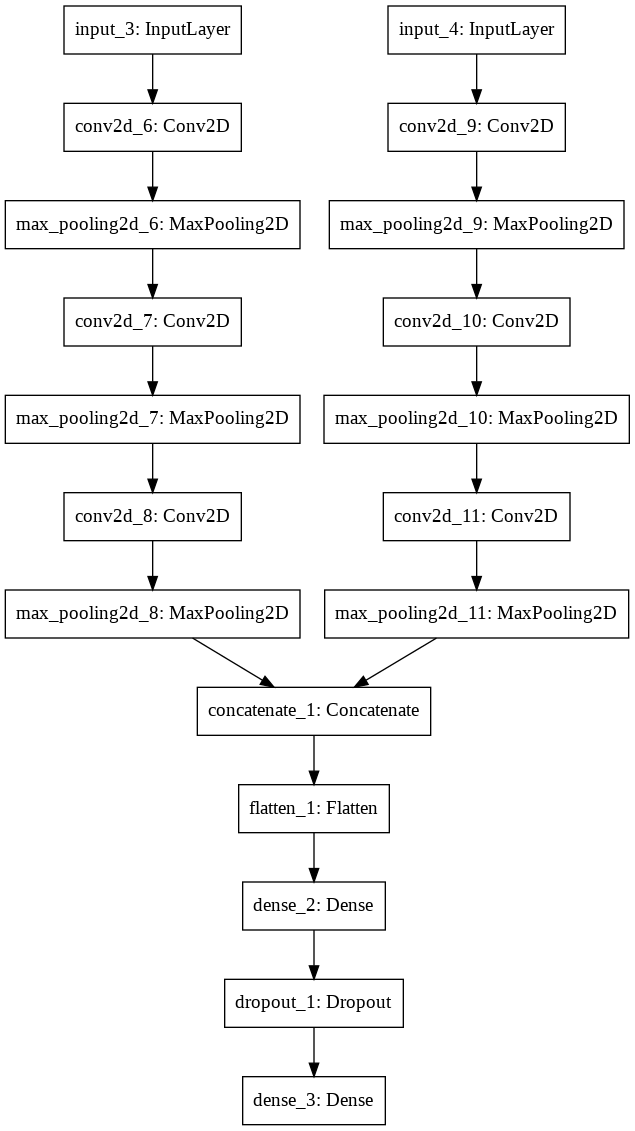

In [0]:
two_ch_cnn = create_2ch_cnn()
two_ch_cnn.summary()
plot_model(two_ch_cnn)

In [0]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('two_ch_cnn_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
two_ch_cnn.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_two_ch_cnn = two_ch_cnn.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=500,
        validation_data=validation_generator,
        validation_steps = n_train_img // 128 // 5,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(two_ch_cnn, 'two_ch_cnn_end.h5')
!cp model* "/content/gdrive/My Drive/models/"

Epoch 1/500
 4/20 [=====>........................] - ETA: 12s - loss: 0.6857 - acc: 0.5352
Epoch 00001: val_loss improved from inf to 0.68567, saving model to two_ch_cnn_best.h5
20/20 [==============================] - 14s 677ms/step - loss: 1.2634 - acc: 0.5208 - val_loss: 0.6857 - val_acc: 0.5352
Epoch 2/500
 4/20 [=====>........................] - ETA: 11s - loss: 0.6804 - acc: 0.5371
Epoch 00002: val_loss improved from 0.68567 to 0.68042, saving model to two_ch_cnn_best.h5
20/20 [==============================] - 11s 540ms/step - loss: 0.7401 - acc: 0.5485 - val_loss: 0.6804 - val_acc: 0.5371
Epoch 3/500
 4/20 [=====>........................] - ETA: 12s - loss: 0.6870 - acc: 0.5000
Epoch 00003: val_loss did not improve from 0.68042
20/20 [==============================] - 11s 559ms/step - loss: 0.6863 - acc: 0.5545 - val_loss: 0.6870 - val_acc: 0.5000
Epoch 4/500
 4/20 [=====>........................] - ETA: 12s - loss: 0.6845 - acc: 0.5430
Epoch 00004: val_loss did not improve fro

In [0]:
# History of accuracy and loss
tra_loss = history_two_ch_cnn.history['loss']
tra_acc = history_two_ch_cnn.history['acc']
val_loss = history_two_ch_cnn.history['val_loss']
val_acc = history_two_ch_cnn.history['val_acc']

# Total number of epochs training
epochs = range(1, len(tra_acc)+1)
end_epoch = len(tra_acc)

# Epoch when reached the validation loss minimum
opt_epoch = val_loss.index(min(val_loss)) + 1

# Loss and accuracy on the validation set
end_val_loss = val_loss[-1]
end_val_acc = val_acc[-1]
opt_val_loss = val_loss[opt_epoch-1]
opt_val_acc = val_acc[opt_epoch-1]

# Loss and accuracy on the test set
opt_two_ch_cnn = models.load_model('two_ch_cnn_best.h5')
test_loss, test_acc = two_ch_cnn.evaluate([test_abn_images, test_base_images], test_labels, verbose=False)
opt_test_loss, opt_test_acc = opt_two_ch_cnn.evaluate([test_abn_images, test_base_images], test_labels, verbose=False)

print("Dual input CNN\n")

print("Epoch [end]: %d" % end_epoch)
print("Epoch [opt]: %d" % opt_epoch)
print("Valid accuracy [end]: %.4f" % end_val_acc)
print("Valid accuracy [opt]: %.4f" % opt_val_acc)
print("Test accuracy [end]:  %.4f" % test_acc)
print("Test accuracy [opt]:  %.4f" % opt_test_acc)
print("Valid loss [end]: %.4f" % end_val_loss)
print("Valid loss [opt]: %.4f" % opt_val_loss)
print("Test loss [end]:  %.4f" % test_loss)
print("Test loss [opt]:  %.4f" % opt_test_loss)

Dual input CNN

Epoch [end]: 268
Epoch [opt]: 188
Valid accuracy [end]: 0.8945
Valid accuracy [opt]: 0.9062
Test accuracy [end]:  0.8542
Test accuracy [opt]:  0.8720
Valid loss [end]: 0.2877
Valid loss [opt]: 0.2320
Test loss [end]:  0.6290
Test loss [opt]:  0.4116


In [0]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

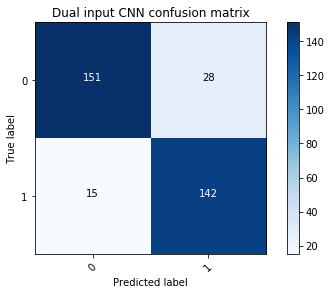

In [0]:
pred = opt_two_ch_cnn.predict([test_abn_images, test_base_images])

pred_classes = np.rint(pred)
confusion_mtx = confusion_matrix(test_labels, pred_classes) 
plot_confusion_matrix(confusion_mtx, classes=range(2), normalize=False, title='Dual input CNN confusion matrix')

In [0]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

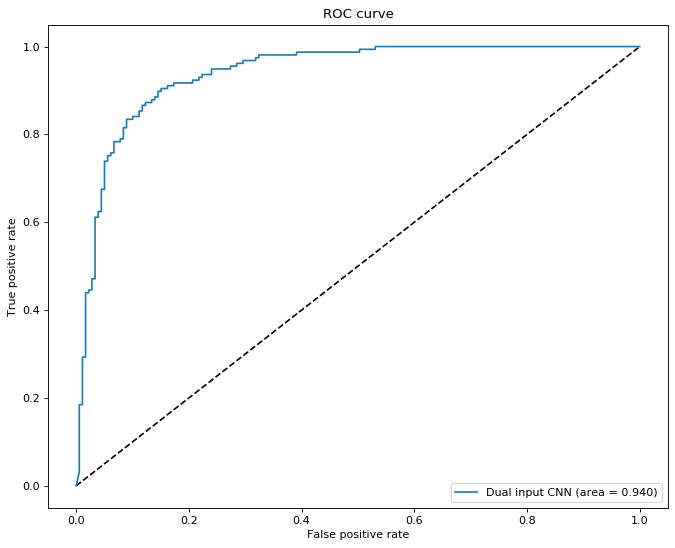

In [0]:
plot_roc([pred], names=['Dual input CNN'])